In [13]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config
from sklearn.metrics import mean_squared_error

In [2]:
data_path = 'mitdb/'

In [3]:
# Get the list of all record files in the folder
# List of Patients
data = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

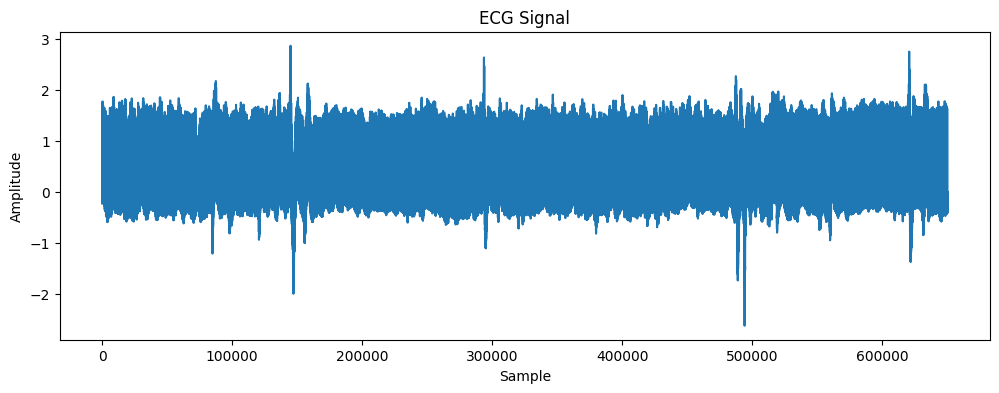

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [5]:
import numpy as np

# Menghitung kekuatan sinyal (Signal Power)
signal_power = np.var(sig)  # sig adalah sinyal asli

# Menghitung kekuatan noise (Noise Power)
# Untuk data EKG, noise seringkali dianggap sebagai seluruh sinyal karena noise dalam data EKG bervariasi
# Anda dapat menggunakan seluruh sinyal sebagai noise
noise_power = np.var(sig)

# Menghitung SNR
snr = 10 * np.log10(signal_power / noise_power)

print("SNR:", snr)


SNR: 0.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [7]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [14]:
# Membangun model Deep RNN Autoencoder
def build_autoencoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder = LSTM(latent_dim, return_sequences=True)(inputs)
    encoder = LSTM(latent_dim)(encoder)

    # Decoder
    decoder = RepeatVector(input_shape[0])(encoder)
    decoder = LSTM(latent_dim, return_sequences=True)(decoder)
    decoder = TimeDistributed(Dense(input_shape[1]))(decoder)

    # Membuat model autoencoder
    autoencoder = Model(inputs, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [17]:
# Fungsi untuk menghitung Signal-to-Noise Ratio (SNR)
def calculate_snr(clean_data, denoised_data):
    noise = clean_data - denoised_data
    signal_power = np.sum(clean_data ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [18]:
# Fungsi untuk menghitung Root Mean Square Error (RMSE)
def calculate_rmse(clean_data, denoised_data):
    mse = mean_squared_error(clean_data.flatten(), denoised_data.flatten())
    rmse = np.sqrt(mse)
    return rmse

In [8]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

Train:  [     1      2      3 ... 162496 162497 162498] Test:  [     0      4     12 ... 162488 162493 162499]
Train data:  [ 0.23942199  0.23942199  0.23942199 ... -0.59026283 -0.61989443
 -0.61989443] Test data:  [ 0.23942199  0.23942199  0.31350099 ... -0.45692063 -0.53099963
 -0.59026283]
Epoch 1/100
254/254 [==============================] - 6s 7ms/step - loss: 0.3805 - root_mean_squared_error: 0.6168 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1022
Epoch 2/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 3/100
254/254 [==============================] - 1s 4ms/step - loss: 9.1097e-04 - root_mean_squared_error: 0.0302 - val_loss: 6.8179e-04 - val_root_mean_squared_error: 0.0261
Epoch 4/100
254/254 [==============================] - 1s 4ms/step - loss: 5.6610e-04 - root_mean_squared_error: 0.0238 - val_loss: 5.6818e-04 - val_root_mean_squared_error: 0.023

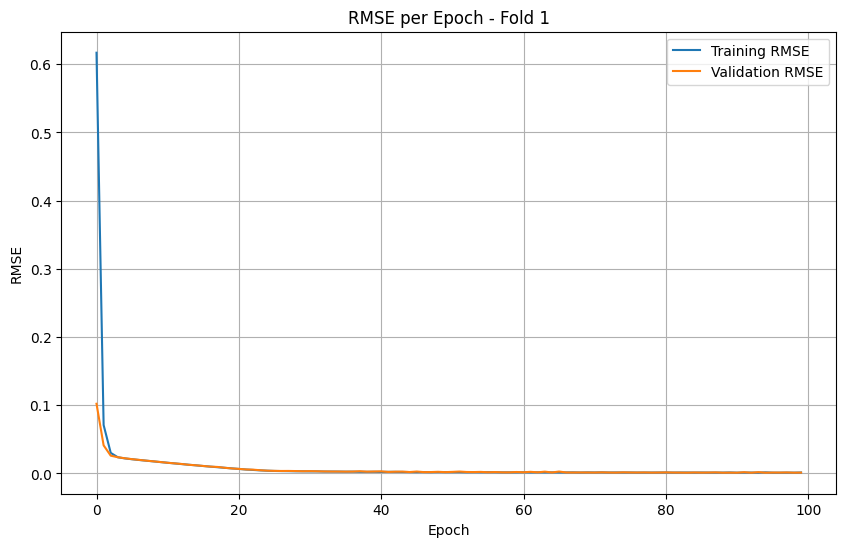

1016/1016 [==============================] - 3s 2ms/step
57.507453285506934
Signal to Noise Ratio (SNR) fold-1: 57.507453285506934
Root Mean Squared Error (RMSE) fold-1: 0.0013323776399597636
Train:  [     0      1      2 ... 162497 162498 162499] Test:  [    22     23     31 ... 162492 162494 162496]
Train data:  [ 0.23942199  0.23942199  0.23942199 ... -0.61989443 -0.61989443
 -0.59026283] Test data:  [ 0.19497459  0.25423779  0.25423779 ... -0.50136803 -0.53099963
 -0.59026283]
Epoch 1/100
254/254 [==============================] - 10s 13ms/step - loss: 0.4125 - root_mean_squared_error: 0.6422 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 2/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 3/100
254/254 [==============================] - 1s 4ms/step - loss: 9.0727e-04 - root_mean_squared_error: 0.0301 - val_loss: 6.7157e-04 - val_root_mean_squared

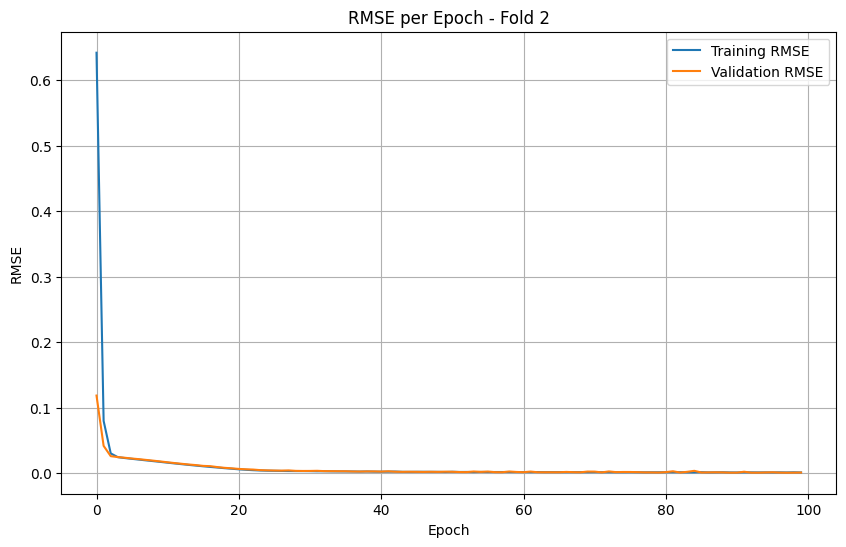

1016/1016 [==============================] - 3s 2ms/step
60.90349675907181
Signal to Noise Ratio (SNR) fold-2: 60.90349675907181
Root Mean Squared Error (RMSE) fold-2: 0.0009012082568085125
Train:  [     0      2      4 ... 162497 162498 162499] Test:  [     1      3      7 ... 162484 162485 162487]
Train data:  [ 0.23942199  0.23942199  0.23942199 ... -0.61989443 -0.61989443
 -0.59026283] Test data:  [ 0.23942199  0.23942199  0.23942199 ... -0.50136803 -0.50136803
 -0.47173643]
Epoch 1/100
254/254 [==============================] - 10s 13ms/step - loss: 0.3883 - root_mean_squared_error: 0.6232 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 2/100
254/254 [==============================] - 2s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 3/100
254/254 [==============================] - 2s 7ms/step - loss: 8.4595e-04 - root_mean_squared_error: 0.0291 - val_loss: 5.7392e-04 - val_root_mean_squared_e

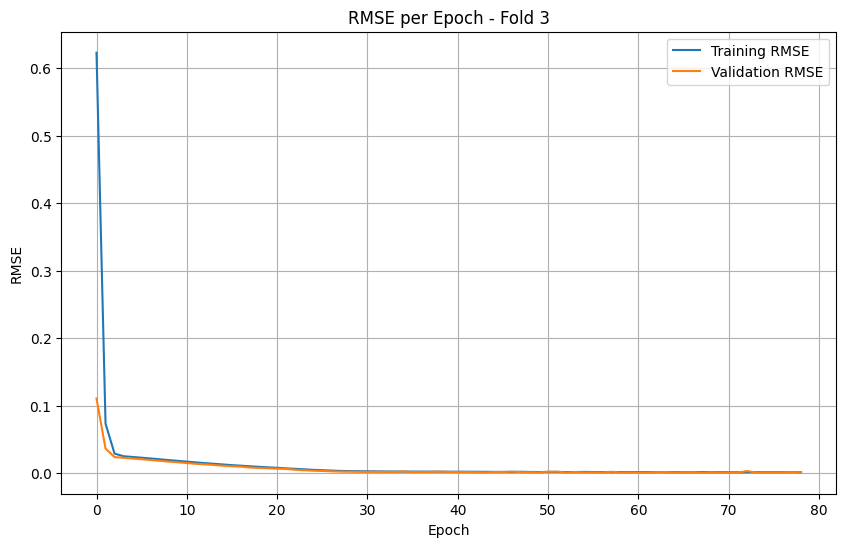

1016/1016 [==============================] - 3s 2ms/step
62.1687938617195
Signal to Noise Ratio (SNR) fold-3: 62.1687938617195
Root Mean Squared Error (RMSE) fold-3: 0.0007790409860776173
Train:  [     0      1      3 ... 162495 162496 162499] Test:  [     2      6      9 ... 162489 162497 162498]
Train data:  [ 0.23942199  0.23942199  0.23942199 ... -0.60507863 -0.59026283
 -0.59026283] Test data:  [ 0.23942199  0.23942199  0.25423779 ... -0.44210483 -0.61989443
 -0.61989443]
Epoch 1/100
254/254 [==============================] - 10s 13ms/step - loss: 0.4124 - root_mean_squared_error: 0.6422 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 2/100
254/254 [==============================] - 2s 7ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 3/100
254/254 [==============================] - 2s 7ms/step - loss: 6.4353e-04 - root_mean_squared_error: 0.0254 - val_loss: 4.8453e-04 - val_root_mean_squared_err

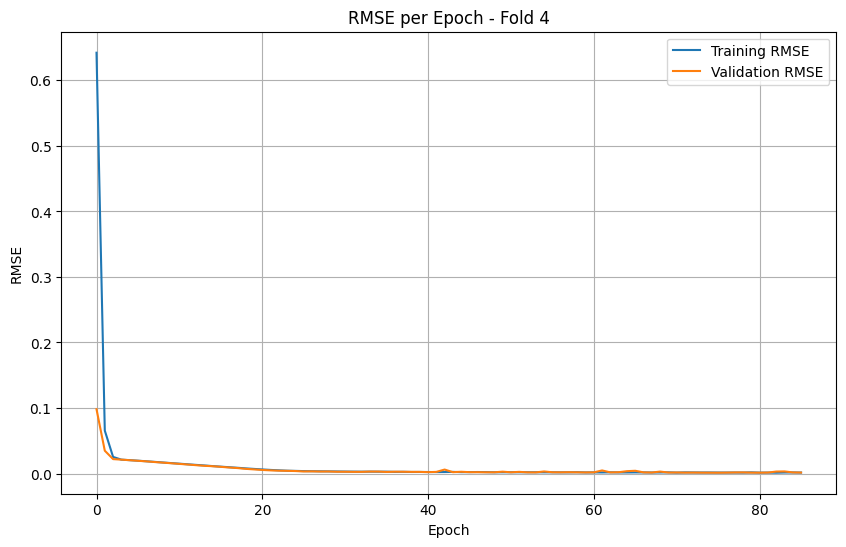

1016/1016 [==============================] - 3s 2ms/step
58.14472201410684
Signal to Noise Ratio (SNR) fold-4: 58.14472201410684
Root Mean Squared Error (RMSE) fold-4: 0.0012381233077482525
Train:  [     0      1      2 ... 162497 162498 162499] Test:  [     5     10     15 ... 162482 162491 162495]
Train data:  [ 0.23942199  0.23942199  0.23942199 ... -0.61989443 -0.61989443
 -0.59026283] Test data:  [ 0.23942199  0.20979039  0.28386939 ... -0.48655223 -0.48655223
 -0.60507863]
Epoch 1/100
254/254 [==============================] - 10s 14ms/step - loss: 0.3910 - root_mean_squared_error: 0.6253 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 2/100
254/254 [==============================] - 2s 8ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 3/100
254/254 [==============================] - 2s 8ms/step - loss: 9.9475e-04 - root_mean_squared_error: 0.0315 - val_loss: 4.3754e-04 - val_root_mean_squared_e

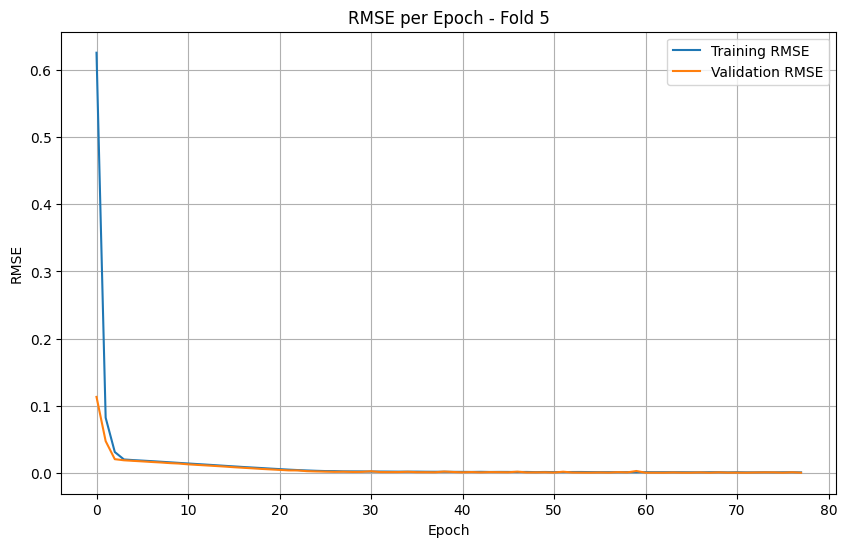

1016/1016 [==============================] - 3s 2ms/step
62.10644348875913
Signal to Noise Ratio (SNR) fold-5: 62.10644348875913
Root Mean Squared Error (RMSE) fold-5: 0.0007846533360837629


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

result_snr = []
result_rmse = []
list_denoised_data = []
i = 1
for train, test in kfold.split(sign):
    # Print index data train dan test
    print("Train: ", train, "Test: ", test)
    # Print isi data train dan test
    print("Train data: ", sig[train], "Test data: ", sig[test])

    # Mendapatkan data train dan test
    X_train, X_test = sign[train], sign[test]

    # Pra-pemrosesan data
    X_train = (X_train - np.mean(X_train)) / np.std(X_train)
    X_test = (X_test - np.mean(X_test)) / np.std(X_test)

    # Mengubah dimensi input ke bentuk yang diharapkan oleh layer LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

    # Menentukan dimensi input
    input_shape = X_train.shape[1:]

    # Menentukan dimensi latent space
    latent_dim = 16

    # Membangun model autoencoder
    autoencoder = build_autoencoder(input_shape, latent_dim)
    
    # Compile the model with loss function and metrics
    autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    
    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Fit the model with callbacks
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test), callbacks=[early_stop])

    # Plot RMSE per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Epoch - Fold {i}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Melakukan denoising pada data test
    denoised_data = autoencoder.predict(X_test)

    # Menghitung SNR dan RMSE
    snr = calculate_snr(X_test, denoised_data)
    print(snr)
    rmse = calculate_rmse(X_test, denoised_data)

    # Tampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    list_denoised_data.append(denoised_data)
    i += 1

In [20]:
# Menambahkan rata-rata dari hasil SNR
average_snr = np.mean(result_snr)

# Mencetak hasil SNR dan rata-rata
k = 1
for snr_value in result_snr:
    print(f"Hasil SNR ke-{k}: {snr_value}")
    k += 1

# Mencetak rata-rata SNR
print(f"Rata-rata SNR: {average_snr}")


Hasil SNR ke-1: 57.507453285506934
Hasil SNR ke-2: 60.90349675907181
Hasil SNR ke-3: 62.1687938617195
Hasil SNR ke-4: 58.14472201410684
Hasil SNR ke-5: 62.10644348875913
Rata-rata SNR: 60.166181881832834


In [21]:
# Menambahkan rata-rata dari hasil RMSE
average_rmse = np.mean(result_rmse)

# Mencetak hasil RMSE dan rata-rata
k = 1
for rmse_value in result_rmse:
    print(f"Hasil RMSE ke-{k}: {rmse_value}")
    k += 1

# Mencetak rata-rata RMSE
print(f"Rata-rata RMSE: {average_rmse}")


Hasil RMSE ke-1: 0.0013323776399597636
Hasil RMSE ke-2: 0.0009012082568085125
Hasil RMSE ke-3: 0.0007790409860776173
Hasil RMSE ke-4: 0.0012381233077482525
Hasil RMSE ke-5: 0.0007846533360837629
Rata-rata RMSE: 0.0010070807053355816
